In [1]:
import os
from pathlib import Path

testfolder = 'Simulations/1axis'

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in Simulations/1axis


In [2]:
import bifacial_radiance as br
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)
print("pyplot ", plt.matplotlib.__version__)

Working on a  Darwin 21.6.0
Python version  3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
Pandas version  2.0.3
bifacial_radiance version  0.4.2+164.ge460768.dirty
pyplot  3.7.2


In [4]:
simulationname = '1axis-groundscan'

# Location
lat = 39.7555
lon = -105.2211

# Scene Parameters
azimuth_ang=90 # Facing south
tilt=30

# MakeModule Parameters
moduletype='PVmod'
numpanels=1
module_x = 2 # m
module_y = 1 # m. slope we will measure
sensorsy=2
sensorsground=5

# SceneDict Parameters
pitch = 6 # m
albedo = 0.2
clearance_height = 0.5 # m  
nMods = 4 
nRows = 3

sceneDict = {'tilt':10,'pitch':3,'clearance_height':0.2,'azimuth':180, 'nMods': 20, 'nRows': 7} 

In [5]:
demo = br.RadianceObj(simulationname,path = testfolder)
demo.setGround(albedo)
epwfile = demo.getEPW(lat, lon)

path = Simulations/1axis
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_CO_Golden-NREL.724666_TMY3.epw
 ... OK!


In [6]:
module=demo.makeModule(name=moduletype,x=module_x,y=module_y)


Module Name: PVmod
Module PVmod updated in module.json
Pre-existing .rad file objects/PVmod.rad will be overwritten



In [7]:
metdata = demo.readWeatherFile(epwfile, coerce_year=2021, starttime='2021-06-01', endtime='2021-06-30_23')

8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs/metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [8]:
demo.gendaylit(timeindex=0)  

'skies/sky2_39.74_-105.18_2021-06-01_0500.rad'

In [9]:
scene = demo.makeScene(module,sceneDict)

In [10]:
octfile = demo.makeOct()

Created 1axis-groundscan.oct


In [11]:
analysis = br.AnalysisObj(octfile, demo.name)

In [12]:
hub_height = 1.5
pitch = 5.7
sazm = 180
fixed_tilt_angle = None
gcr = 2 / pitch
cumulativesky = True

trakerParams = {
    'limit_angle': 50,
    'angledelta': 30,
    'backtrack': True,
    'gcr': gcr,
    'cumulativesky': cumulativesky,
    'azimuth': sazm,
    'fixed_tilt_angle': fixed_tilt_angle
}

In [13]:
trackerdict = demo.set1axis(**trakerParams)

Saving file EPWs/1axis_-60.0.csv, # points: 90
Saving file EPWs/1axis_-30.0.csv, # points: 90
Saving file EPWs/1axis_-0.0.csv, # points: 90
Saving file EPWs/1axis_30.0.csv, # points: 90
Saving file EPWs/1axis_60.0.csv, # points: 90


In [14]:
if cumulativesky:
    demo.genCumSky1axis()
else:
    demo.gendaylit1axis()

message: There were 90 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-60.0.rad
message: There were 90 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-30.0.rad
message: There were 89 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-0.0.rad
message: There were 90 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_30.0.rad
message: There were 90 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_60.0.rad


In [15]:
sceneDict = {
    'pitch': pitch,
    'hub_height': hub_height,
    'nMods': 5,
    'nRows': 2,
    'tilt': fixed_tilt_angle,
    'sazm': sazm
}

In [16]:
trakerdict = demo.makeScene1axis(module=moduletype, sceneDict=sceneDict)
trakerdict = demo.makeOct1axis()


Making .rad files for cumulativesky 1-axis workflow
5 Radfiles created in /objects/

Making 5 octfiles in root directory.
Created 1axis_-60.0.oct
Created 1axis_-30.0.oct
Created 1axis_-0.0.oct
Created 1axis_30.0.oct
Created 1axis_60.0.oct


In [17]:
sensorsgroundvalues = np.array([2, 3, 5, 10, 20, 30, 100, 150, 200, 250, 300, 400, 500])
angles = np.array([-0.0, -30.0, -60.0, 30.0, 60.0])

In [19]:
resultsdict = {}

for i, sensorsground in enumerate(sensorsgroundvalues):
    print(f"sensorsground: {sensorsground}")
    trakerdict = demo.analysis1axis(customname='1-axis groundscan ' + str(sensorsground), sensorsy=1, modWanted = 2, rowWanted = 1, sensorsground=sensorsground)
    
    for i, angle in enumerate(angles):
        for i, x in enumerate(trakerdict[angle]['Results'][0]['AnalysisObj'].frontx):
            if x >= 1 and x <= pitch-1:
                if (sensorsground, angle) in resultsdict:
                    resultsdict[(sensorsground, angle)] += trakerdict[angle]['Results'][0]['AnalysisObj'].Wm2Front
                else:
                    resultsdict[(sensorsground, angle)] = trakerdict[angle]['Results'][0]['AnalysisObj'].Wm2Front

    print("")

sensorsground: 2
Linescan in process: 1axis_-60.01-axis groundscan 2_Row1_Module2_Front
Linescan in process: 1axis_-60.01-axis groundscan 2_Row1_Module2_Back
Saved: results/irr_1axis_-60.01-axis groundscan 2_Row1_Module2_Front.csv
Saved: results/irr_1axis_-60.01-axis groundscan 2_Row1_Module2_Back.csv
Index: -60.0. Wm2Front: 32816.885. Wm2Back: 5748.446
Linescan in process: 1axis_-30.01-axis groundscan 2_Row1_Module2_Front
Linescan in process: 1axis_-30.01-axis groundscan 2_Row1_Module2_Back
Saved: results/irr_1axis_-30.01-axis groundscan 2_Row1_Module2_Front.csv
Saved: results/irr_1axis_-30.01-axis groundscan 2_Row1_Module2_Back.csv
Index: -30.0. Wm2Front: 37921.225. Wm2Back: 6299.755
Linescan in process: 1axis_-0.01-axis groundscan 2_Row1_Module2_Front
Linescan in process: 1axis_-0.01-axis groundscan 2_Row1_Module2_Back
Saved: results/irr_1axis_-0.01-axis groundscan 2_Row1_Module2_Front.csv
Saved: results/irr_1axis_-0.01-axis groundscan 2_Row1_Module2_Back.csv
Index: -0.0. Wm2Front: 

Linescan in process: 1axis_60.01-axis groundscan 20_Row1_Module2_Back
Saved: results/irr_1axis_60.01-axis groundscan 20_Row1_Module2_Front.csv
Saved: results/irr_1axis_60.01-axis groundscan 20_Row1_Module2_Back.csv
Index: 60.0. Wm2Front: 20953.767. Wm2Back: 5878.687999999999

sensorsground: 30
Linescan in process: 1axis_-60.01-axis groundscan 30_Row1_Module2_Front
Linescan in process: 1axis_-60.01-axis groundscan 30_Row1_Module2_Back
Saved: results/irr_1axis_-60.01-axis groundscan 30_Row1_Module2_Front.csv
Saved: results/irr_1axis_-60.01-axis groundscan 30_Row1_Module2_Back.csv
Index: -60.0. Wm2Front: 33135.90966666667. Wm2Back: 5732.865999999999
Linescan in process: 1axis_-30.01-axis groundscan 30_Row1_Module2_Front
Linescan in process: 1axis_-30.01-axis groundscan 30_Row1_Module2_Back
Saved: results/irr_1axis_-30.01-axis groundscan 30_Row1_Module2_Front.csv
Saved: results/irr_1axis_-30.01-axis groundscan 30_Row1_Module2_Back.csv
Index: -30.0. Wm2Front: 41034.761999999995. Wm2Back: 63

Saved: results/irr_1axis_-0.01-axis groundscan 250_Row1_Module2_Front.csv
Saved: results/irr_1axis_-0.01-axis groundscan 250_Row1_Module2_Back.csv
Index: -0.0. Wm2Front: 39284.97876. Wm2Back: 6356.827
Linescan in process: 1axis_30.01-axis groundscan 250_Row1_Module2_Front
Linescan in process: 1axis_30.01-axis groundscan 250_Row1_Module2_Back
Saved: results/irr_1axis_30.01-axis groundscan 250_Row1_Module2_Front.csv
Saved: results/irr_1axis_30.01-axis groundscan 250_Row1_Module2_Back.csv
Index: 30.0. Wm2Front: 31500.33484. Wm2Back: 6151.4710000000005
Linescan in process: 1axis_60.01-axis groundscan 250_Row1_Module2_Front
Linescan in process: 1axis_60.01-axis groundscan 250_Row1_Module2_Back
Saved: results/irr_1axis_60.01-axis groundscan 250_Row1_Module2_Front.csv
Saved: results/irr_1axis_60.01-axis groundscan 250_Row1_Module2_Back.csv
Index: 60.0. Wm2Front: 20504.927079999998. Wm2Back: 5838.263

sensorsground: 300
Linescan in process: 1axis_-60.01-axis groundscan 300_Row1_Module2_Front
L

In [20]:
trakerdict

{-0.0: {'csvfile': 'EPWs/1axis_-0.0.csv',
  'surf_azm': 90.00000409455455,
  'surf_tilt': 0.0,
  'datetime': Index(['2021-06-01 05:00:00', '2021-06-01 12:00:00', '2021-06-01 13:00:00',
         '2021-06-02 05:00:00', '2021-06-02 12:00:00', '2021-06-02 13:00:00',
         '2021-06-03 05:00:00', '2021-06-03 12:00:00', '2021-06-03 13:00:00',
         '2021-06-04 05:00:00', '2021-06-04 12:00:00', '2021-06-04 13:00:00',
         '2021-06-05 05:00:00', '2021-06-05 12:00:00', '2021-06-05 13:00:00',
         '2021-06-06 05:00:00', '2021-06-06 12:00:00', '2021-06-06 13:00:00',
         '2021-06-07 05:00:00', '2021-06-07 12:00:00', '2021-06-07 13:00:00',
         '2021-06-08 05:00:00', '2021-06-08 12:00:00', '2021-06-08 13:00:00',
         '2021-06-09 05:00:00', '2021-06-09 12:00:00', '2021-06-09 13:00:00',
         '2021-06-10 05:00:00', '2021-06-10 12:00:00', '2021-06-10 13:00:00',
         '2021-06-11 05:00:00', '2021-06-11 12:00:00', '2021-06-11 13:00:00',
         '2021-06-12 05:00:00', '20

In [21]:
resulsbyangle = {}

for i, angle in enumerate(angles):
    results = []
    for i, sensorsground in enumerate(sensorsgroundvalues):
        if (sensorsground, angle) in resultsdict:
            results.append(np.mean(resultsdict[(sensorsground, angle)]))
        else:
            results.append(0)
    
    resulsbyangle[angle] = results

In [22]:
resulsbyangle

{-0.0: [0,
  31442.599999999995,
  108455.19600000001,
  224881.86,
  459707.1599999999,
  695654.9699999999,
  2489727.961600003,
  3734437.6447999952,
  5101757.62655001,
  6364166.5591200115,
  7697545.890400026,
  10155498.397974981,
  12800123.658000028],
 -30.0: [0,
  39053.653333333335,
  119311.302,
  242040.04200000004,
  487774.3440000002,
  738625.7159999999,
  2636726.675199997,
  3923259.2127999924,
  5315379.361499988,
  6671524.811039991,
  7877007.717933296,
  10818182.004500033,
  13196449.076399935],
 -60.0: [0,
  32561.656666666666,
  96844.20000000001,
  198416.54400000002,
  399345.78600000025,
  596446.3739999998,
  2097644.7743999967,
  3156801.1904000035,
  4282329.993500007,
  5223428.16912,
  6406899.890333336,
  8602223.714499963,
  10525478.508719971],
 30.0: [0,
  34931.32666666667,
  98024.75399999999,
  192876.03,
  377275.36199999996,
  568473.1380000002,
  2023448.7168000012,
  3026120.6143999994,
  4034938.316500011,
  5103054.244079998,
  6143316.7075

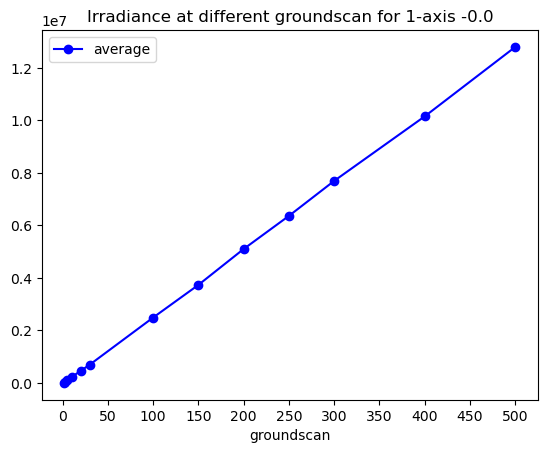

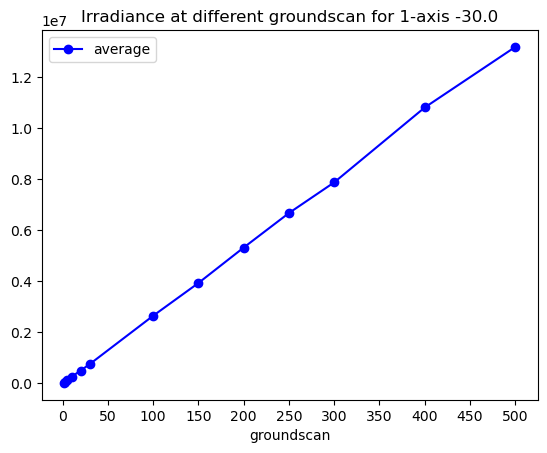

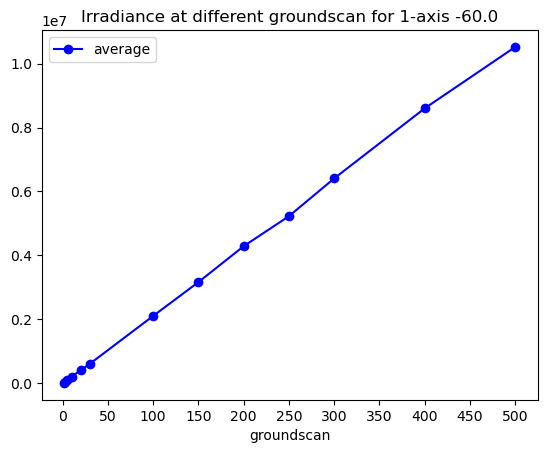

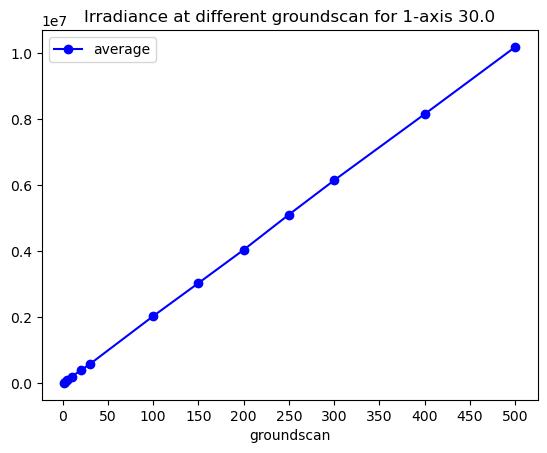

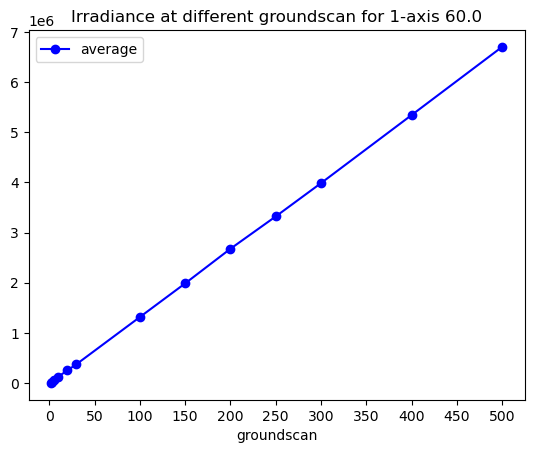

In [23]:
for i, angle in enumerate(angles):
    df = pd.DataFrame({
        'groundscan': sensorsgroundvalues,
        'average': resulsbyangle[angle]
    })

    df.plot(x='groundscan', y='average', marker='o', color='blue')
    plt.xticks(np.arange(0, 501, 50))
    plt.title(f'Irradiance at different groundscan for 1-axis {angle}')
    plt.show()

In [24]:
# one graph for all angles
resultsbysensor = {}

for i, sensorsground in enumerate(sensorsgroundvalues):
    resultsarr = []
    for i, angle in enumerate(angles):
        if (sensorsground, angle) in resultsdict:
            resultsarr.append(np.mean(resultsdict[(sensorsground, angle)]))
                          
    resultsbysensor[sensorsground] = np.mean(resultsarr)

/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
resultsbysensor

{2: nan,
 3: 32214.233999999997,
 5: 97437.6732,
 10: 196936.85280000002,
 20: 395109.57120000006,
 30: 594605.8415999999,
 100: 2112474.97088,
 150: 3165349.752319999,
 200: 4282267.542410004,
 250: 5336794.394063998,
 300: 6422241.6495999945,
 400: 8614269.53649498,
 500: 10682674.88731197}

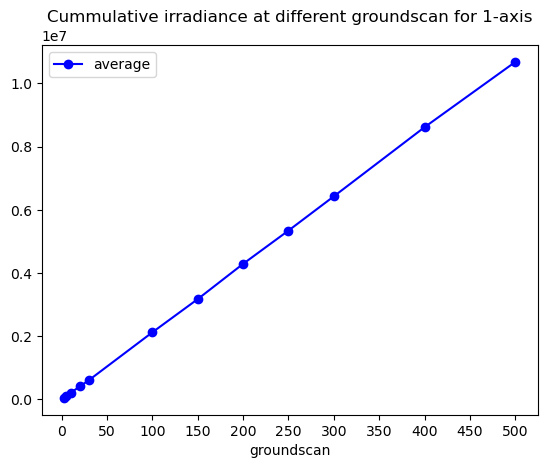

In [26]:
df1 = pd.DataFrame({
    'groundscan': sensorsgroundvalues,
    'average': resultsbysensor.values()
})

df1.plot(x='groundscan', y='average', marker='o', color='blue')
plt.xticks(np.arange(0, 501, 50))
plt.title('Cummulative irradiance at different groundscan for 1-axis')
plt.show()